<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         431 non-null    object 
 1   Breed               431 non-null    object 
 2   Age                 431 non-null    int64  
 3   Gender              431 non-null    object 
 4   Weight              431 non-null    float64
 5   Symptom_1           431 non-null    object 
 6   Symptom_2           431 non-null    object 
 7   Symptom_3           431 non-null    object 
 8   Symptom_4           431 non-null    object 
 9   Duration            431 non-null    object 
 10  Appetite_Loss       431 non-null    object 
 11  Vomiting            431 non-null    object 
 12  Diarrhea            431 non-null    object 
 13  Coughing            431 non-null    object 
 14  Labored_Breathing   431 non-null    object 
 15  Lameness            431 non-null    object 
 16  Skin_Les

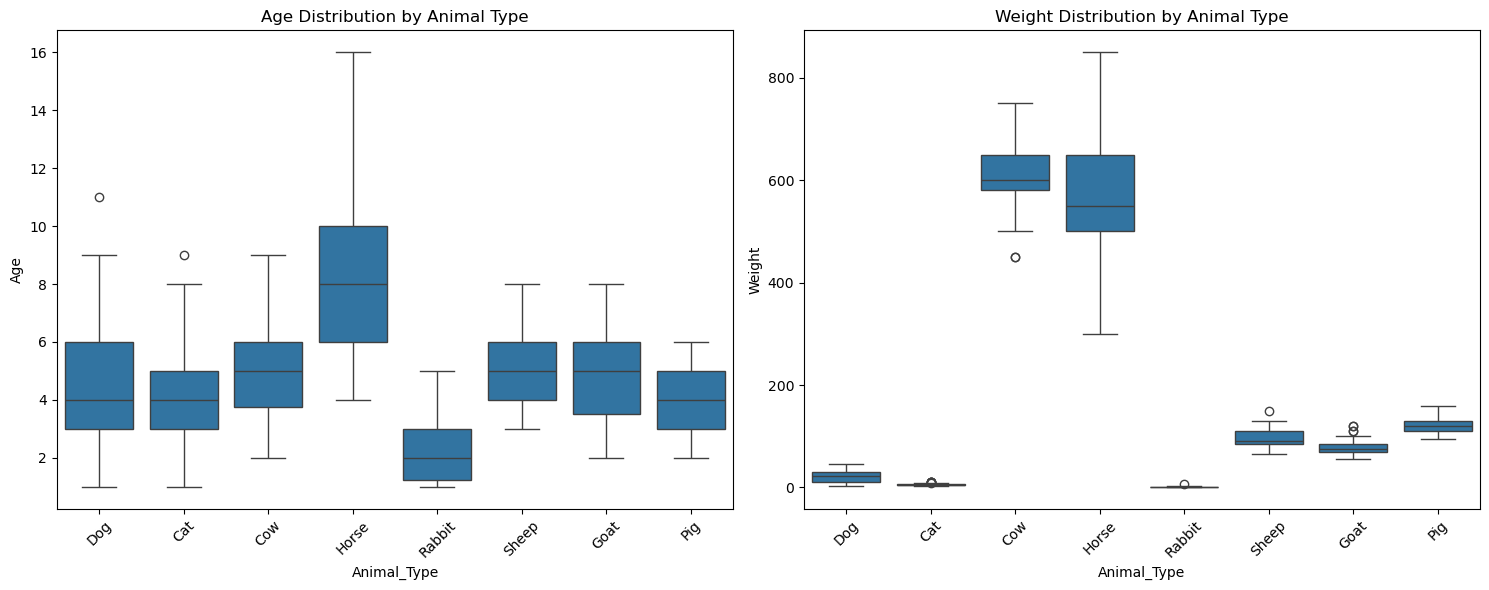

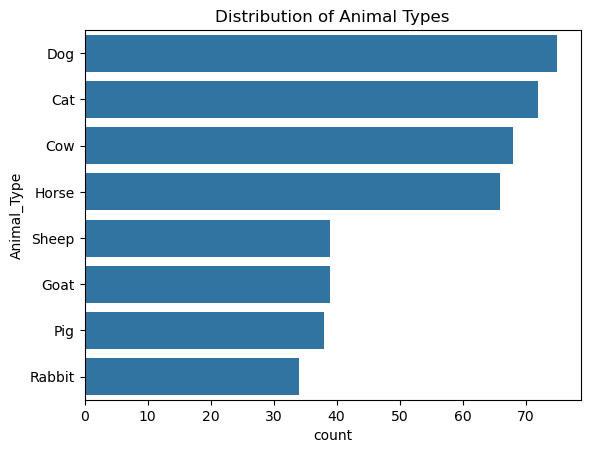

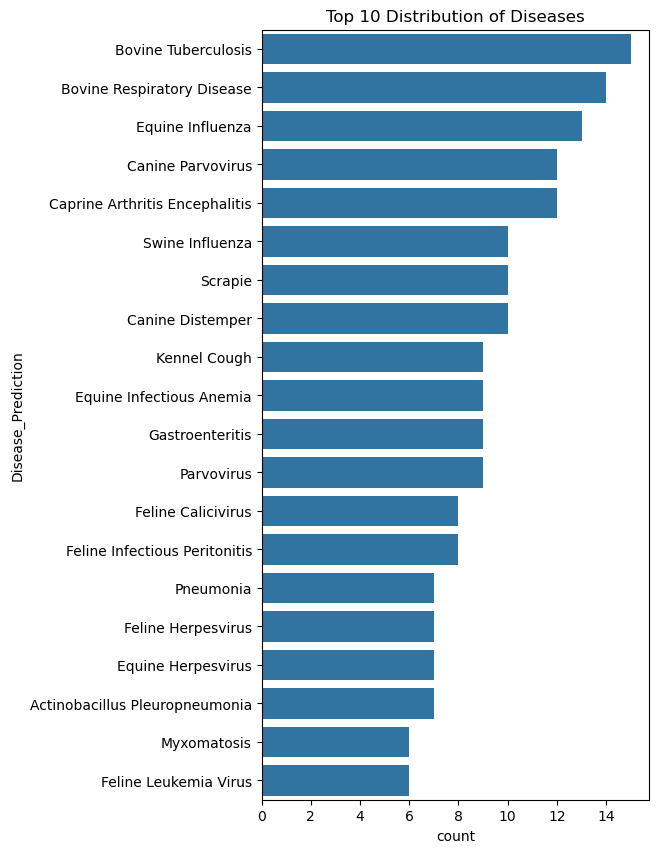

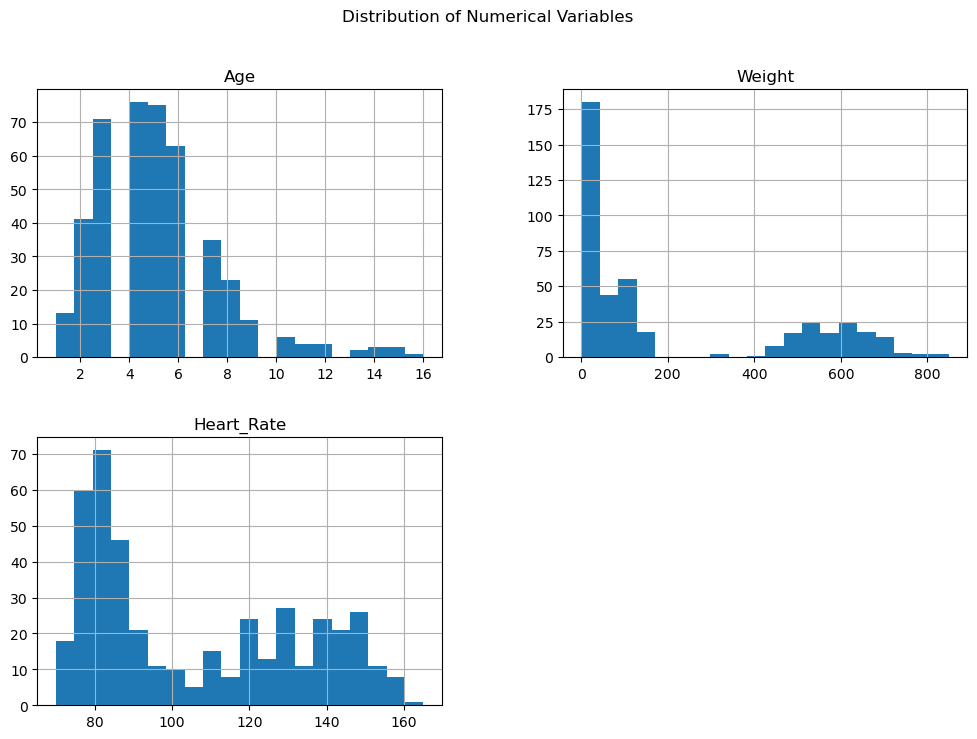

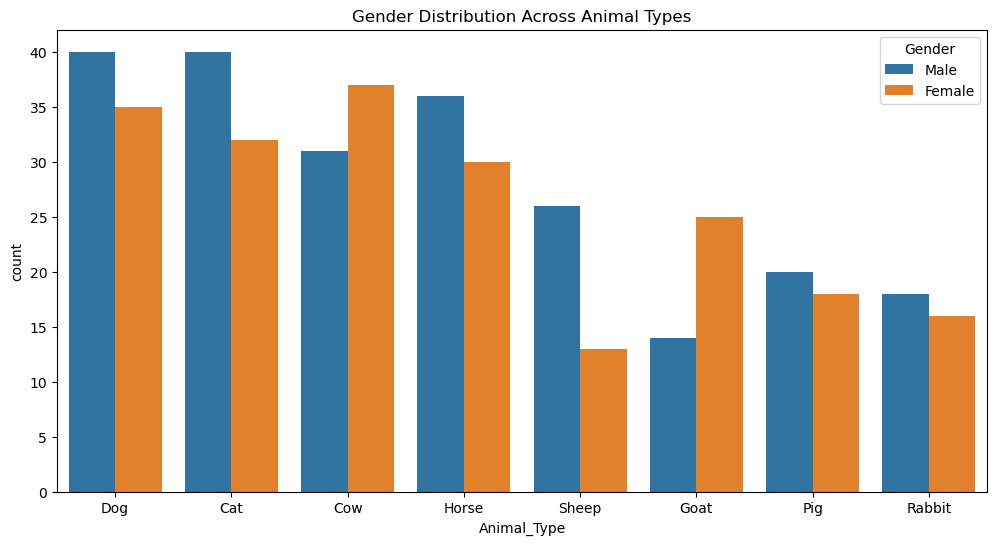

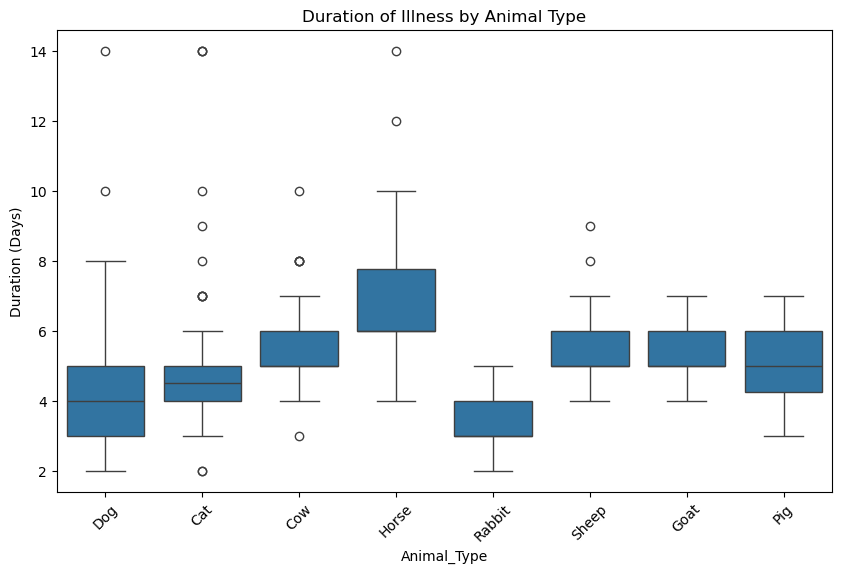

1.6.1


In [3]:
%run Visualization.ipynb

In [4]:
# Compute class frequencies
target_col = 'Disease_Prediction'
value_counts = df[target_col].value_counts(normalize=True)

# Group rare classes
rare_classes = value_counts[value_counts < 0.02].index

# Replace rare classes with 'Other'
df[target_col] = df[target_col].replace(rare_classes, 'Other')

In [5]:
# Binary flags for symptoms
symptom_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing',
                'Labored_Breathing', 'Lameness', 'Skin_Lesions',
                'Nasal_Discharge', 'Eye_Discharge']
for col in symptom_cols:
    df[col] = (df[col] == 'Yes').astype(int)

# Temperature conversion
df['Body_Temperature'] = df['Body_Temperature'].astype(str).str.replace('°C', '', regex=False).astype(float)


# Duration conversion
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)
df.loc[df['Duration'].str.contains('week'), 'Duration_Num'] *= 7

# Age groups
df['Age_Group'] = pd.cut(df['Age'],
                        bins=[0, 1, 3, 5, 10, float('inf')],
                        labels=['Infant', 'Young', 'Adult', 'Middle_Aged', 'Senior'])

In [34]:
# Weight categories
def categorize_weight(row):
    if row['Animal_Type'] == 'Dog':
        bins = [0, 10, 25, 40, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    elif row['Animal_Type'] == 'Cat':
        bins = [0, 4, 6, 8, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    else:
        return 'NA'
    return pd.cut([row['Weight']], bins=bins, labels=labels)[0]

df['Weight_Category'] = df.apply(categorize_weight, axis=1)

In [35]:
df.shape

(431, 25)

In [91]:
# Train-test split
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


In [92]:
X_train.shape

(344, 24)

In [93]:
# Feature scaling
scaler = StandardScaler()
num_features = ['Age', 'Weight', 'Body_Temperature', 'Duration_Num']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [ ]:
X_train.shape
df = X_train.select_dtypes(['object']).values

array(['1 week', '10 days', '2 days', '2 weeks', '3 days', '4 days',
       '5 days', '6 days', '7 days', '8 days', '9 days', 'Aberdeen Angus',
       'Abyssinian', 'Akita', 'Alpine', 'American Curl',
       'American Quarter', 'Andalusian', 'Angora', 'Angus', 'Appaloosa',
       'Appetite Loss', 'Arabian', 'Ayrshire', 'Beagle', 'Belgian',
       'Belted Galloway', 'Bengal', 'Berkshire', 'Blackface', 'Boer',
       'Bombay', 'Border Collie', 'Border Leicester', 'Boxer', 'Brahman',
       'British Shorthair', 'Bulldog', 'Burmese', 'Cat', 'Charolais',
       'Chester White', 'Cheviot', 'Chihuahua', 'Clydesdale',
       'Cocker Spaniel', 'Corgi', 'Corriedale', 'Coughing', 'Cow',
       'Dachshund', 'Decreased Milk Yield', 'Dehydration', 'Devon Rex',
       'Dexter', 'Diarrhea', 'Doberman Pinscher', 'Dog', 'Dorper',
       'Dorset', 'Duroc', 'Dutch', 'English Angora', 'English Lop',
       'Eye Discharge', 'Female', 'Fever', 'Finnsheep', 'German Shepherd',
       'Giant', 'Goat', 'Golden R

In [87]:
# Categorical features
cat_features = ['Animal_Type', 'Breed', 'Gender', 'Age_Group', 'Weight_Category']
encoders = {}

for feature in cat_features:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    all_unique_values = pd.concat([X_train[feature], X_test[feature]]).unique()

    enc = LabelEncoder().fit(all_unique_values)
    encoders[feature] = enc

    X_train[feature] = enc.transform(X_train[feature])
    X_test[feature] = X_test[feature].apply(
        lambda x: enc.transform([x])[0] if x in enc.classes_ else -1
    )

# One-hot encode
objs_train = X_train.select_dtypes(['object']).columns
X_train = pd.get_dummies(X_train, columns=objs_train)
X_test = pd.get_dummies(X_test, columns=objs_train)

# Align columns
X_train, X_test = X_train.align(X_test, axis=1, join='left', fill_value=0)


In [88]:
X_test.shape

(87, 105)

In [23]:
# Encode y_train and y_test
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Store class weights
weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))

y_test_not_encoded = le.inverse_transform(y_test_encoded)
class_dict = dict(zip(np.unique(y_test_encoded), np.unique(y_test_not_encoded)))
print("class dict: ", class_dict)

print("Class Weights:", weights_dict)
print("Train Encoded Classes:", np.unique(y_train_encoded))
print("Test Encoded Classes:", np.unique(y_test_encoded))

class dict:  {0: 'Bovine Respiratory Disease', 1: 'Bovine Tuberculosis', 2: 'Canine Distemper', 3: 'Canine Parvovirus', 4: 'Caprine Arthritis Encephalitis', 5: 'Equine Infectious Anemia', 6: 'Equine Influenza', 7: 'Gastroenteritis', 8: 'Kennel Cough', 9: 'Other', 10: 'Parvovirus', 11: 'Scrapie', 12: 'Swine Influenza'}
Class Weights: {0: 2.4055944055944054, 1: 2.2051282051282053, 2: 3.3076923076923075, 3: 2.646153846153846, 4: 2.646153846153846, 5: 3.78021978021978, 6: 2.646153846153846, 7: 3.78021978021978, 8: 3.78021978021978, 9: 0.1107177341486965, 10: 3.78021978021978, 11: 3.3076923076923075, 12: 3.3076923076923075}
Train Encoded Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Test Encoded Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [30]:
X_train.shape

(344, 24)

In [32]:
%store X_train
%store X_test
%store y_train
%store y_test

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


In [33]:
X_train.shape

(344, 24)

Index([], dtype='object')